In [40]:
import numpy as np
import qutip as qt
from qutip import tensor, basis, ket, ket2dm, cphase
import itertools
from matplotlib.colors import LightSource
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import sys
path = os.getcwd()+"/AigisResults"
saving_path = os.getcwd()+"/WriteUp/Plots/"
sys.path.append(path)
sys.path.append(saving_path)
import pickle
from QuantumNetworkEnvsClean import QuantumNetworkPWC


rc_fonts = {
    "font.family": "serif",
    "font.size": 20,
    'figure.figsize': (5, 3),
    "text.usetex": True,
}
rcParams.update(rc_fonts)
rcParams['figure.dpi']= 300

In [46]:
stnames = ['GHZ3', 'Dicke3_2', 'Cluster']
nums = [2,1,1]
cut_offs = [7,14,-1]
fidelities = {}
timez = []
for idx, name in enumerate(stnames):
    load_path = path+"/ModifiedReward/{}/Trial{}/Best".format(name, nums[idx])

    resolution=10
    best_chromosome = np.loadtxt(load_path+"/chromosome")
    with open(load_path+"/env", 'rb') as pickle_file:
        original_env = pickle.load(pickle_file)   
    dimension=original_env.cav_dim
    env = QuantumNetworkPWC(N_qubits=original_env.N, N_steps=original_env.N_steps,
                                     max_time=original_env.max_time, cav_dim=dimension,
                                     resolution=resolution, max_coupling=original_env.max_coupling/original_env.g,
                                     max_driving=original_env.max_driving/original_env.g,
                                    init_state=original_env.init_state, targ_state=original_env.targ_state_ket,
                                    save_path=load_path, sharpness=original_env.sharpness)
    edited_chrome = np.copy(best_chromosome)
    chrome = np.hsplit(edited_chrome,env.N_controls)
    for i in range(env.N_controls):
        chrome[i][cut_offs[idx]:] = 0
    new_best_chromosome = np.concatenate(chrome) 
    noise_ls = [[0,0,0],[1,0,1],[0,1,0]]
    fidz = []
    if name=='GHZ3':
        cutt_idx = env.resolution * 10
    else:
        cutt_idx = -1 
    for i in range(len(noise_ls)):
        env.plot_initializer(new_best_chromosome, Noise=True, noise_factors=noise_ls[i])
        fidz.append(env.fid[:cutt_idx])
    timez.append(env.times[:cutt_idx])
    fidelities[name] = fidz


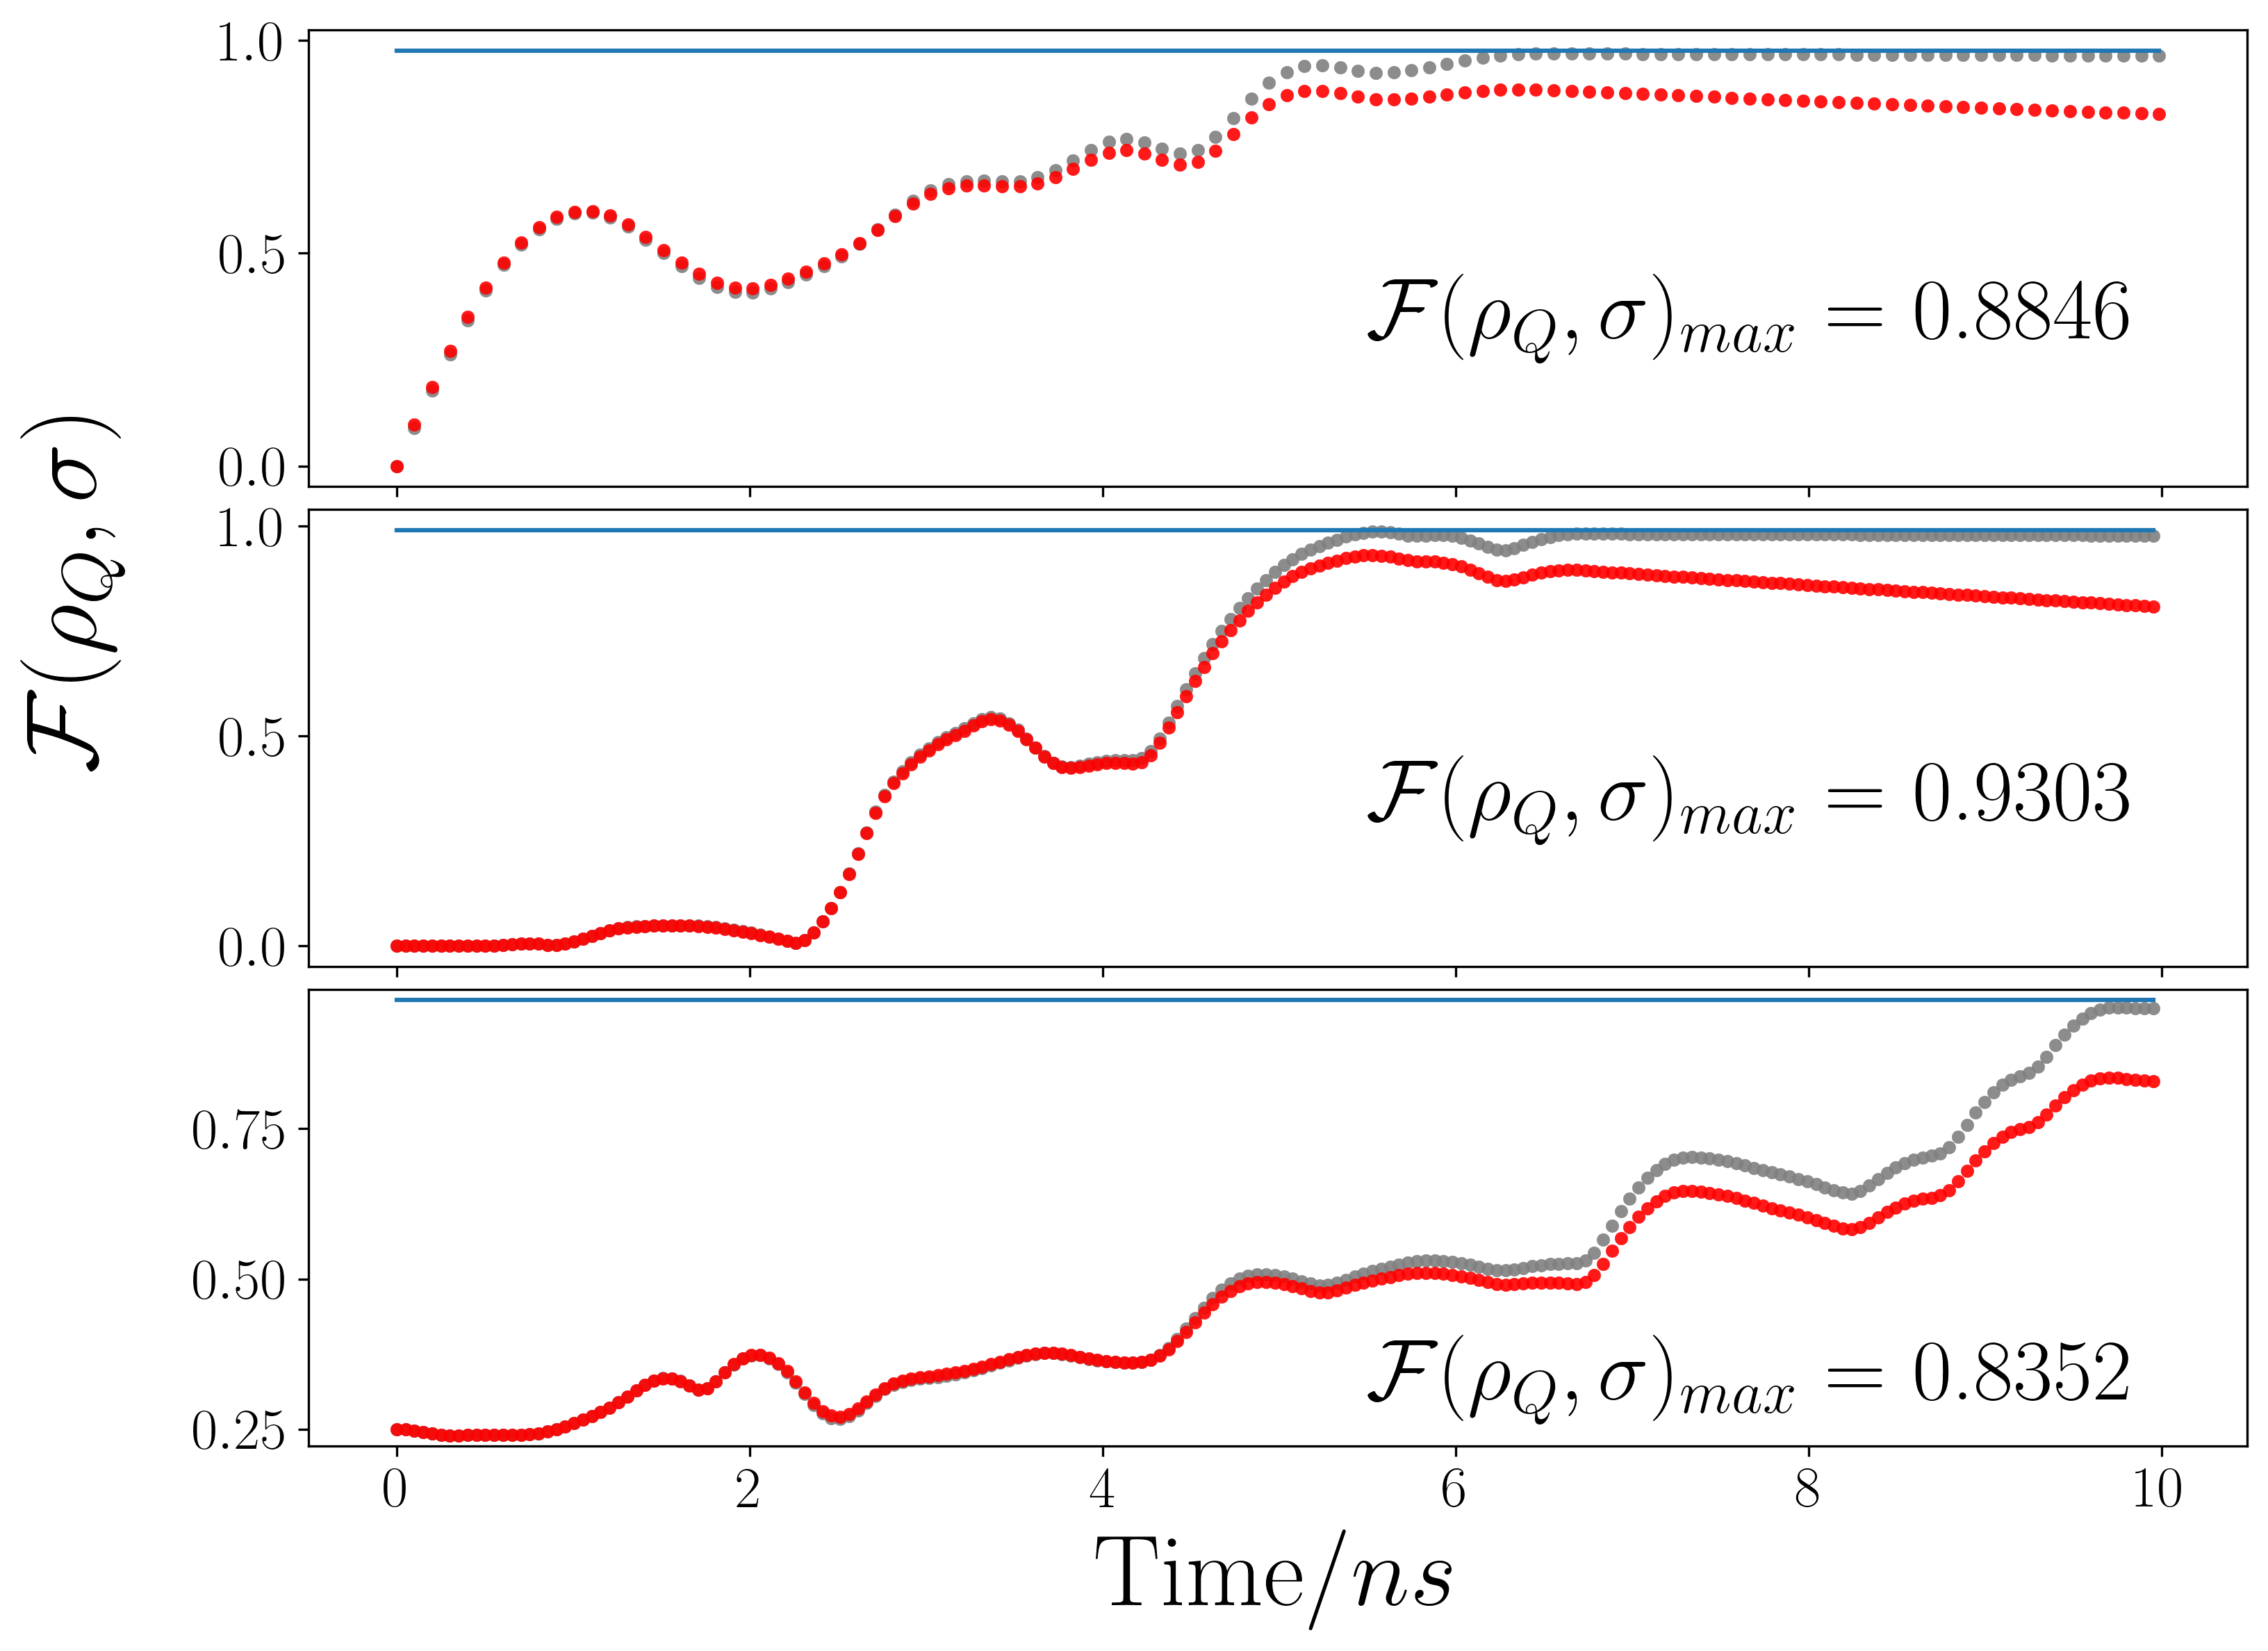

In [80]:
plot_range = 0
# env.resolution*4
colours = ['grey', 'red']
fig, axs = plt.subplots(3,1, figsize=(12,9), sharex=True)
for idx, name in enumerate(stnames):
    axs[idx].scatter(timez[idx], fidelities[name][1][plot_range:], 
                linewidth=0.1, s=20, alpha=0.9, color=colours[0], label=name)
    # plt.scatter(env.times[plot_range:], fidelities[1][plot_range:], linewidth=0.1, s=20, color='orange', alpha=0.7)
    axs[idx].plot(timez[idx], np.ones_like(timez[idx])* np.max(fidelities[name][0]))
    axs[idx].text(5.5,0.3,r"$\mathcal{F}(\rho_{Q}, \sigma)_{max}$"+" = {}".format(np.round(np.max(fidelities[name][2]), decimals=4)), 
            fontsize=30)
    axs[idx].scatter(timez[idx], fidelities[name][2][plot_range:], 
                linewidth=0.1, s=20, alpha=0.9, color=colours[1], label=name)
plt.xlabel("Time/$ns$", fontsize=35)
fig.text(0.01, 0.5, r"$\mathcal{F}(\rho_{Q}, \sigma)$", fontsize=35, rotation='vertical')

plt.margins(0.025)
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.savefig(saving_path+"DecoherenceFid", dpi=300)